ZIP            0
GBAUJ          0
FLAECHE        0
GWAERZH1       0
GWAERZH1TXT    0
GENH1          0
GENH1TXT       0
GWAERDATH1     0
CATEGORY       0
dtype: int64


/Users/adrianhohn/anaconda3/envs/Machine-Learning/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adrianhohn/anaconda3/envs/Machine-Learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adrianhohn/anaconda3/envs/Machine-Learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adrianhohn/anaconda3/envs/Machine-Learning/lib/python3.11/site-pack

Accuracy: 0.3817003962512623
Classification Report:
                                                   precision    recall  f1-score   support

                 Abwärme (innerhalb des Gebäudes)       0.00      0.00      0.00         9
                                           Andere       0.00      0.00      0.00       682
                                     Elektrizität       0.00      0.00      0.00     10717
                                      Erdregister       0.00      0.00      0.00        88
                             Erdwärme (generisch)       0.00      0.00      0.00      2506
                                    Erdwärmesonde       0.00      0.00      0.00      4442
                       Fernwärme (Hochtemperatur)       0.00      0.00      0.00       290
                     Fernwärme (Niedertemperatur)       0.00      0.00      0.00        95
                            Fernwärme (generisch)       0.49      0.01      0.03     12266
                                     

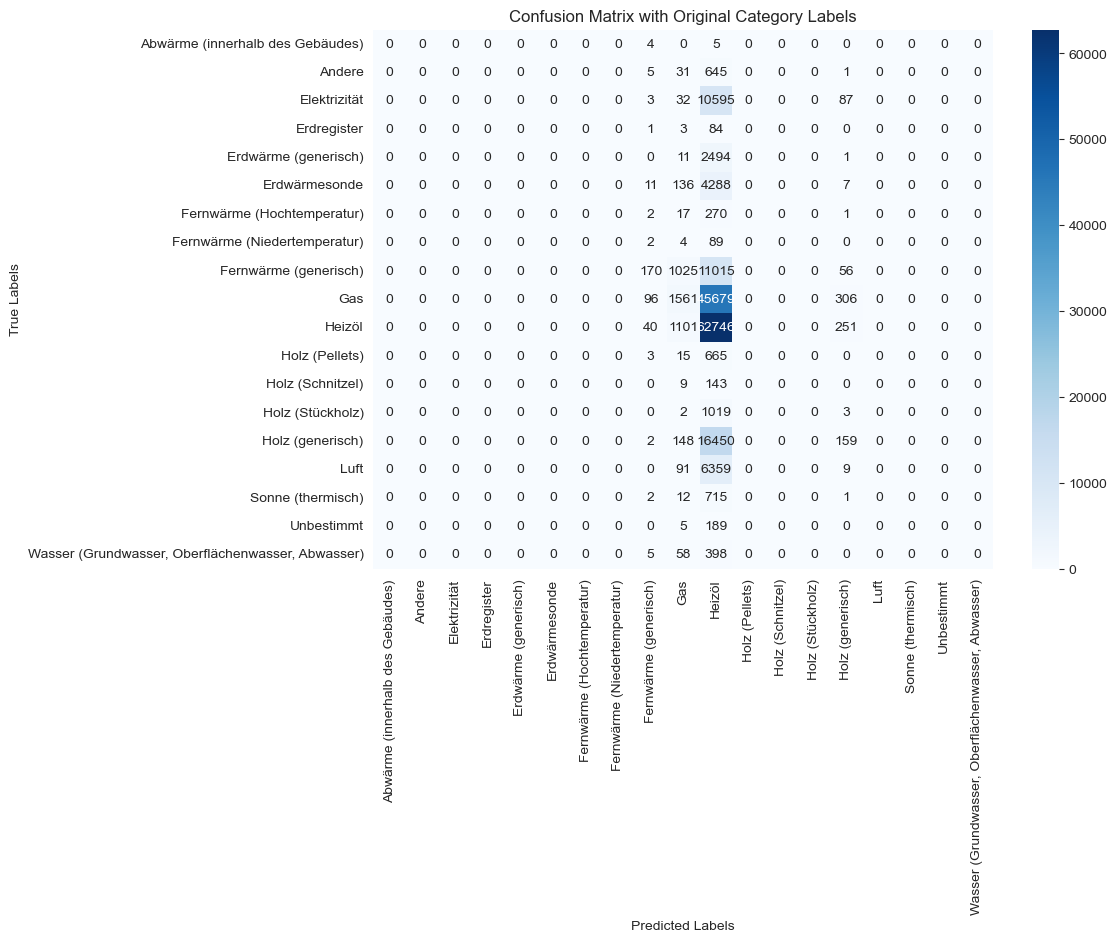

In [36]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
engine = create_engine('sqlite:///../data/data.sqlite')

query_training_data = """select DPLZ4 as ZIP,
             GBAUJ,
             GAREA * GASTW as FLAECHE,
             GWAERZH1,
             w1.CODTXTLD   as GWAERZH1TXT,
             GENH1,
             c1.CODTXTLD   as GENH1TXT,
             GWAERDATH1
      from building b,
           entrance e,
           (select CECODID, CODTXTLD from codes WHERE CMERKM = 'GWAERZH1') w1,
           (select CECODID, CODTXTLD from codes WHERE CMERKM = 'GENH1') c1
      WHERE b.GABBJ == ''
        AND b.GBAUJ != ''
        AND (GENH1 NOT IN ('', '7500', '7598') OR GENH2 NOT IN ('', '7500', '7598'))
        AND b.GWAERZH1 = w1.CECODID
        AND b.GENH1 = c1.CECODID
        AND e.EGID = b.EGID
        AND (GSTAT NOT in ('1005', '1007', '1008'))"""

df = pd.read_sql_query(query_training_data, engine)

df['ZIP'] = pd.to_numeric(df['ZIP'], errors='coerce')
df['GBAUJ'] = pd.to_numeric(df['GBAUJ'], errors='coerce')
df['FLAECHE'] = pd.to_numeric(df['FLAECHE'], errors='coerce')
df['GENH1'] = pd.to_numeric(df['GENH1'], errors='coerce')

# Convert GENH1 to numerical categories
label_encoder = LabelEncoder()
df['CATEGORY'] = label_encoder.fit_transform(df['GENH1TXT'])
label_mappings = {index: label for index, label in enumerate(label_encoder.classes_)}
df.head()

# Check for missing values
print(df.isna().sum())

df.dropna(inplace=True)

# Splitting data into features and target
X = df[['GBAUJ', 'FLAECHE']]
y = df['CATEGORY']
# 
# Optionally, scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# Initialize and train the logistic regression model
model = LogisticRegression(solver='saga', max_iter=1000)
model.fit(X_train, y_train)
 
# Predict the categories of the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, predictions, target_names=label_mappings.values())

# Print the classification report
print("Classification Report:")
print(report)

# 
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mappings.values(), yticklabels=label_mappings.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Original Category Labels')
plt.show()